In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

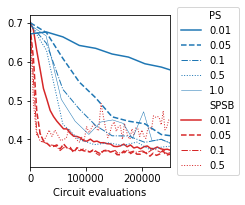

In [3]:
# CONV
folder = "data_quanv"

losses_name = "new_fixed_diffseed_losses_all_4_{}_{}_{}_{}.npy"
accs_name = "new_fixed_diffseed_accs_all_4_{}_{}_{}_{}.npy"
evals_name = "new_fixed_diffseed_evals_4_{}_{}_{}_{}.npy"


diffs = ['spsb', 'parameter-shift']
num_it = [10, 5]
lrs = [0.01, 0.05, 0.1, 0.5, 1.0]
linestyles = ['-', '--', '-.', ':', '-']
linewidths = [3, 3, 2, 2, 1]
linewidths = np.array(linewidths) * 0.5
colors = [u'#d62728', u'#1f77b4']

n_qubits = 4
n_layers = 3
size = 4
window_size = 3
num_samples = 1000
batch_size = 50
lr=0.01


plot_params = {'steps': {'parameter-shift': 3, 'spsb':10},
               'average_window': {'parameter-shift': 3, 'spsb':10},
}
epochs=8

n_params = n_qubits * n_layers
fig, ax = plt.subplots(facecolor='w')

#Set figure size
w = 2.5
h = 2.8

fig.set_figheight(h)
fig.set_figwidth(w)

lns = []

for (n_it, diff) in zip(num_it, diffs):
    diff_steps = plot_params['steps'][diff]
    diff_window = plot_params['average_window'][diff]
    for lr in lrs:
        if diff == "spsb" and lr == 1.0:
            break
        losses_load_name = folder + "/" + losses_name.format(epochs, lr, diff, batch_size)
        accs_load_name = folder + "/" + accs_name.format(epochs, lr, diff, batch_size)
        evals_load_name = folder + "/" + evals_name.format(epochs, lr, diff, batch_size)

        losses = np.load(losses_load_name, allow_pickle=True)
        accs = np.load(accs_load_name, allow_pickle=True)
        evals = np.load(evals_load_name)

        # Average over iterations
        losses_median = np.median(losses, axis=0)

        # Take rolling average:
        losses_median_avg = np.convolve(losses_median, np.ones((diff_window,))/diff_window, mode='valid')

        # Append first original step
        losses_plot = np.append(losses_median[:diff_window-1], losses_median_avg)

        evals = np.mean(evals, axis=0)

        lns += ax.plot(evals[::diff_steps], losses_plot[::diff_steps], label=f"{lr}", linestyle=linestyles[lrs.index(lr)], linewidth=linewidths[lrs.index(lr)], color=colors[diffs.index(diff)])



PS_label = ax.plot([0.5], [0.5], label="PS", color='w', alpha=1.0)
SPSB_label = ax.plot([0.5], [0.5], label="SPSB", color='w', alpha=1.0)

handles, labels = ax.get_legend_handles_labels()
order = range(len(handles))

# Move PS and SPSB to the front of respective groups
order = [-2, *order[len(lrs)-1:-2], -1, *order[0:len(lrs)-1]]

ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='center left', bbox_to_anchor = (1.02, 0.5, 0.43, 0))

# General plot appearance

plt.xlim(0, 250000)
plt.ylim()
ax.set_xlabel("Circuit evaluations")
# ax.set_ylabel("Loss")

plt.savefig("figs/quanv_loss_rolling.pdf", bbox_inches='tight')

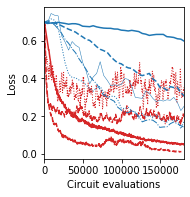

In [4]:
# Thomas LR study data

name_template = 'data_lr_study/{}_{}_niter{}_nfeatures{}_nlayers{}_batchsize{}_nepochs{}_lr{}.npy'

n_iter = 10
n_features = 15
n_layers = 3
batch_size = 25
n_epochs = 20

lrs = [0.01, 0.05, 0.1, 0.5, 1]

diffs = ['spsb', 'ps']

plot_params = {'epochs': {'ps': [10]*len(lrs), 'spsb': [606, 606, 606, 606, 606]},
               'steps': {'ps': 1, 'spsb': 3},
               'average_window': {'ps': 3, 'spsb': 10}}

fig, ax = plt.subplots(facecolor='w')

#Set figure size
w = 2.5
h = 2.8

fig.set_figheight(h)
fig.set_figwidth(w)


for diff in diffs:
    diff_epochs = plot_params['epochs'][diff]
    diff_steps = plot_params['steps'][diff]
    diff_window = plot_params['average_window'][diff]
    for lr, n_epochs in zip(lrs, diff_epochs):
        if diff == 'spsb' and lr == 1:
            break
        try:
            losses_load_name = name_template.format(diff, 'loss', n_iter, n_features, n_layers, batch_size, n_epochs, lr)
            accs_load_name = name_template.format(diff, 'acc', n_iter, n_features, n_layers, batch_size, n_epochs, lr)
            evals_load_name = name_template.format(diff, 'evals', n_iter, n_features, n_layers, batch_size, n_epochs, lr)

            losses = np.load(losses_load_name, allow_pickle=True)
            accs = np.load(accs_load_name, allow_pickle=True)
            evals = np.load(evals_load_name)

            # Average over iterations
            losses_median = np.median(losses, axis=0)
            
            # Take rolling average:
            losses_median_avg = np.convolve(losses_median, np.ones((diff_window,))/diff_window, mode='valid')

            # Append first original step
            losses_plot = np.append(losses_median[:diff_window-1], losses_median_avg)

            lns += ax.plot(evals[::diff_steps], losses_plot[::diff_steps], label=f"{lr}", linestyle=linestyles[lrs.index(lr)], linewidth=linewidths[lrs.index(lr)], color=colors[diffs.index(diff)])

        except FileNotFoundError:
            print("File not found", diff, lr)
            print(accs_load_name)

plt.xlim(0, 180000)
# plt.ylim(0,0.8)
plt.xlabel("Circuit evaluations")
plt.ylabel("Loss")
# plt.legend()
plt.savefig("figs/random_loss_rolling.pdf", bbox_inches='tight')
plt.show()